# Random Forest to predict the Plot


In [1]:
from qiime2 import Visualization
from qiime2 import Artifact, Metadata
from qiime2.plugins import sample_classifier

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/berries'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/berries


## Load data

In [ ]:
%%bash 

# subset to only harvest samples before fitting 
qiime feature-table filter-samples \
  --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --p-where "[Time_point]='Harvest'" \
  --o-filtered-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qza

In [ ]:
!qiime feature-table summarize --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qza --o-visualization /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qzv

# Harvest -  Random Forest: train on one year, test on the others

In [5]:
#!mkdir must-harvest21classify-SplitYear

In [6]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/berries/must-harvest21classify-SplitYear'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/berries/must-harvest21classify-SplitYear


In [7]:
# Load the feature table artifact
feature_table = Artifact.load('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qza')
table = feature_table.view(pd.DataFrame)
print(f'Table: {table.shape}')

Table: (323, 6144)


In [8]:
metadata = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv', sep='\t', index_col=0)
years = metadata['Year'].unique()
# Find Plot_IDs present in all years
plots_in_all_years = set(metadata.groupby('Plot_ID').filter(lambda x: set(x['Year']) == set(years))['Plot_ID'].unique())
# Get all unique Plot_IDs
all_plots = set(metadata['Plot_ID'].unique())
# Find plots not present in all years
plots_not_in_all_years = all_plots - plots_in_all_years
plots_not_in_all_years_list = list(plots_not_in_all_years)

print(f"Plots not present in all years: {plots_not_in_all_years_list}")

Plots not present in all years: ['Lavaux_Plot_11', 'Lavaux_Plot_18']


In [60]:
%%bash 

# subset to only harvest samples before fitting 
qiime feature-table filter-samples \
  --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --p-where "[Year] IN ('2021') AND [Plot_ID] NOT IN ('Lavaux_Plot_11', 'Lavaux_Plot_18')" \
  --o-filtered-table Train_Table.qza

qiime feature-table filter-samples \
  --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --p-where "[Year] IN ('2023') AND [Plot_ID] NOT IN ('Lavaux_Plot_11', 'Lavaux_Plot_18')" \
  --o-filtered-table Test_Table.qza

Saved FeatureTable[Frequency] to: Train_Table.qza
Saved FeatureTable[Frequency] to: Test_Table.qza


In [61]:
# Load the feature table artifact
feature_table_training = Artifact.load('Train_Table.qza')
feature_table_test = Artifact.load('Test_Table.qza')

table_training = feature_table_training.view(pd.DataFrame)
table_test = feature_table_test.view(pd.DataFrame)

total_samples = table_training.shape[0] + table_test.shape[0]
train_percentage = (table_training.shape[0] / total_samples) * 100
test_percentage = (table_test.shape[0] / total_samples) * 100

print(f'Training: {table_training.shape[0]} samples ({train_percentage:.2f}%)')
print(f'Test: {table_test.shape[0]} samples ({test_percentage:.2f}%)')


Training: 193 samples (79.42%)
Test: 50 samples (20.58%)


In [62]:
%%bash

rm -r Fitting-RandomForest

qiime sample-classifier fit-classifier \
        --i-table Train_Table.qza \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
        --m-metadata-column 'Plot_ID' \
        --p-random-state 42 \
        --p-n-jobs 10 \
        --p-n-estimators 10000 \
        --p-estimator 'RandomForestClassifier' \
        --p-parameter-tuning \
        --output-dir Fitting-RandomForest

Saved SampleEstimator[Classifier] to: Fitting-RandomForest/sample_estimator.qza
Saved FeatureData[Importance] to: Fitting-RandomForest/feature_importance.qza


In [67]:
%%bash 

rm -r Predict-Classification 

qiime sample-classifier predict-classification \
    --i-table Test_Table.qza \
    --i-sample-estimator Fitting-RandomForest/sample_estimator.qza \
    --p-n-jobs 10 \
    --output-dir Predict-Classification 

Saved SampleData[ClassifierPredictions] to: Predict-Classification/predictions.qza
Saved SampleData[Probabilities] to: Predict-Classification/probabilities.qza


In [68]:
# Load predictions and probabilities from QIIME2 artifacts
predictions = Artifact.load("Predict-Classification/predictions.qza").view(pd.Series)
probabilities = Artifact.load("Predict-Classification/probabilities.qza").view(pd.DataFrame)

# Load the ground truth labels from metadata
metadata = pd.read_csv("/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv", sep="\t", index_col=0)
y_true = metadata.loc[predictions.index, "Plot_ID"]  # Align indices

/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/q2_sample_classifier/_transformer.py:69: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return pd.to_numeric(df.iloc[:, 0], errors='ignore')


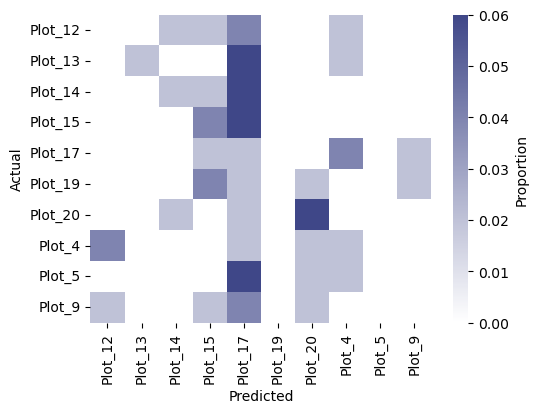

In [69]:
# Assuming y_true and predictions are already defined
cm = confusion_matrix(y_true, predictions)
labels = sorted(y_true.unique())  # Ensure correct label ordering

# Normalize the confusion matrix by the total sum to get proportions
cm_normalized = cm.astype('float') / cm.sum()

# Strip 'Lavaux_' from all labels
clean_labels = [label.replace("Lavaux_", "") for label in labels]

# Define custom colormap from light blue (not white) to deep blue
colors = ["#FFFFFF", "#3F4788FF"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=256)

# Create the heatmap with normalized confusion matrix
plt.figure(figsize=(5.5, 4))
sns.heatmap(cm_normalized, annot=False, fmt=".2f", cmap=custom_cmap, 
            cbar_kws={'label': 'Proportion'},  # Add colorbar label
            xticklabels=clean_labels, yticklabels=clean_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

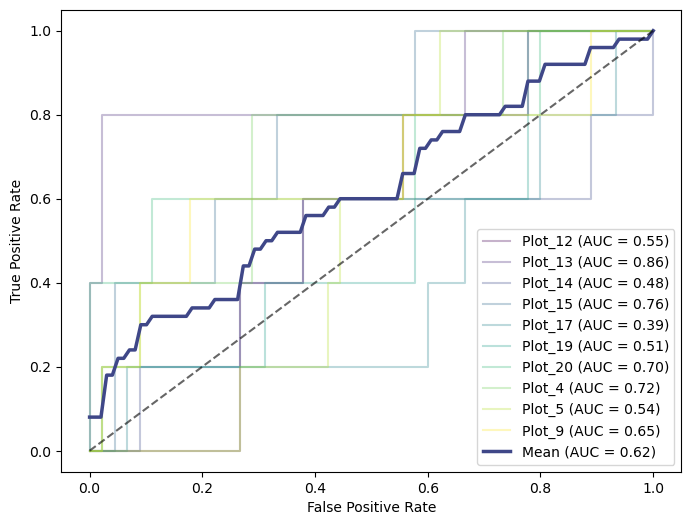

In [70]:
# Convert categorical labels to one-hot encoding
y_true_bin = label_binarize(y_true, classes=labels)

# Get Viridis colors for each class
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))  # Use plt.cm.viridis

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
all_fpr = np.linspace(0, 1, 100)  # Common FPR points for interpolation
mean_tpr = np.zeros_like(all_fpr)  # To store mean TPR

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probabilities[label])
    roc_auc = auc(fpr, tpr)
    
    # Remove "Lavaux_" from the label in the legend
    clean_label = label.replace("Lavaux_", "")

    # Plot individual class ROC curve with Viridis color
    plt.plot(fpr, tpr, label=f"{clean_label} (AUC = {roc_auc:.2f})", 
             color=viridis_colors[i], alpha=0.3, linewidth=1.5)

    # Interpolate TPR for averaging
    mean_tpr += np.interp(all_fpr, fpr, tpr)  

# Compute mean ROC curve
mean_tpr /= len(labels)
mean_auc = auc(all_fpr, mean_tpr)

# Plot the **average ROC curve** (bold, different color)
plt.plot(all_fpr, mean_tpr, color="#3F4788FF", linewidth=2.5, label=f"Mean (AUC = {mean_auc:.2f})")

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


More years
* AUC 0.67 for using 2021, 2022 to predict 2023 
* AUC 0.80 for using 2021, 2023 to predict 2022 
* AUC 0.69 for using 2021 to predict 2022, 2023 

Single years
* AUC 0.74 using 2021 to predict 2022
* AUC 0.62 using 2021 to predict 2023


## Harvest: Random Forest - Nested Cross Validation


In [ ]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/berries'
%cd $workdir

In [ ]:
%%bash 

rm -r must-harvestclassify-NCV-plot

qiime sample-classifier classify-samples-ncv \
  --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-metadata-column Plot_ID \
  --p-random-state 666 \
  --p-n-jobs 10 \
  --p-n-estimators 10000 \
  --p-estimator 'RandomForestClassifier' \
  --output-dir ./must-harvestclassify-NCV-plot/
  

qiime sample-classifier confusion-matrix \
  --i-predictions must-harvestclassify-NCV-plot/predictions.qza \
  --i-probabilities must-harvestclassify-NCV-plot/probabilities.qza \
  --m-truth-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-truth-column Plot_ID \
  --o-visualization must-harvestclassify-NCV-plot/ncv_confusion_matrix.qzv

In [ ]:
Visualization.load('must-harvestclassify-NCV-plot/ncv_confusion_matrix.qzv')

## Harvest dense sampling 2021: Random Forest - Nested Cross Validation

> also tried 'KNeighborsClassifier' but that had bad performance

* note. decreasing the estimator to 1000 decreased the AUC to 0.83 - keep high! 

In [ ]:
%%bash 

rm -r must-harvest21classify-NCV-plot

qiime sample-classifier classify-samples-ncv \
  --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest21_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-metadata-column Plot_ID \
  --p-random-state 666 \
  --p-n-jobs 10 \
  --p-n-estimators 20000 \
  --p-estimator 'RandomForestClassifier' \
  --output-dir ./must-harvest21classify-NCV-plot/
  

qiime sample-classifier confusion-matrix \
  --i-predictions must-harvest21classify-NCV-plot/predictions.qza \
  --i-probabilities must-harvest21classify-NCV-plot/probabilities.qza \
  --m-truth-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-truth-column Plot_ID \
  --o-visualization must-harvest21classify-NCV-plot/ncv_confusion_matrix.qzv

In [ ]:
Visualization.load('must-harvest21classify-NCV-plot/ncv_confusion_matrix.qzv')

### Nicer visualizations!

In [3]:
# Load predictions and probabilities from QIIME2 artifacts
predictions = Artifact.load("must-harvest21classify-NCV-plot/predictions.qza").view(pd.Series)
probabilities = Artifact.load("must-harvest21classify-NCV-plot/probabilities.qza").view(pd.DataFrame)

# Load the ground truth labels from metadata
metadata = pd.read_csv("/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv", sep="\t", index_col=0)
y_true = metadata.loc[predictions.index, "Plot_ID"]  # Align indices

/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/q2_sample_classifier/_transformer.py:69: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return pd.to_numeric(df.iloc[:, 0], errors='ignore')


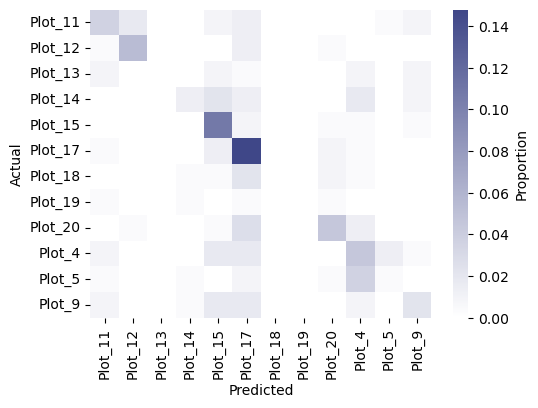

In [6]:
# Assuming y_true and predictions are already defined
cm = confusion_matrix(y_true, predictions)
labels = sorted(y_true.unique())  # Ensure correct label ordering

# Normalize the confusion matrix by the total sum to get proportions
cm_normalized = cm.astype('float') / cm.sum()

# Strip 'Lavaux_' from all labels
clean_labels = [label.replace("Lavaux_", "") for label in labels]

# Define custom colormap from light blue (not white) to deep blue
colors = ["#FFFFFF", "#3F4788FF"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=256)

# Create the heatmap with normalized confusion matrix
plt.figure(figsize=(5.5, 4))
sns.heatmap(cm_normalized, annot=False, fmt=".2f", cmap=custom_cmap, 
            cbar_kws={'label': 'Proportion'},  # Add colorbar label
            xticklabels=clean_labels, yticklabels=clean_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

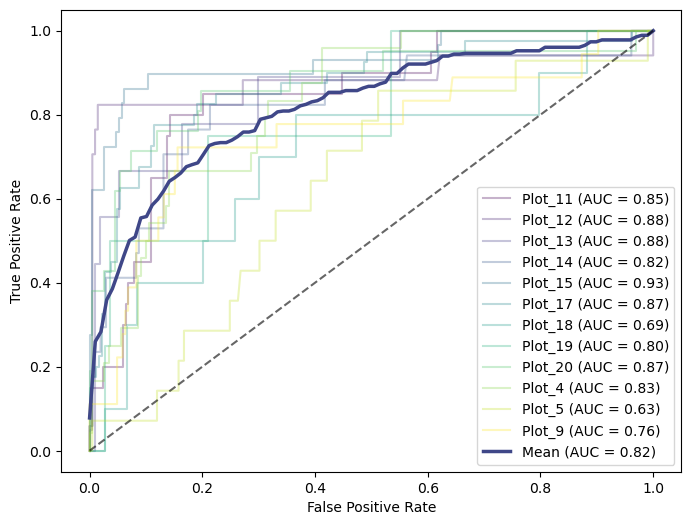

In [7]:
# Convert categorical labels to one-hot encoding
y_true_bin = label_binarize(y_true, classes=labels)

# Get Viridis colors for each class
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))  # Use plt.cm.viridis

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
all_fpr = np.linspace(0, 1, 100)  # Common FPR points for interpolation
mean_tpr = np.zeros_like(all_fpr)  # To store mean TPR

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probabilities[label])
    roc_auc = auc(fpr, tpr)
    
    # Remove "Lavaux_" from the label in the legend
    clean_label = label.replace("Lavaux_", "")

    # Plot individual class ROC curve with Viridis color
    plt.plot(fpr, tpr, label=f"{clean_label} (AUC = {roc_auc:.2f})", 
             color=viridis_colors[i], alpha=0.3, linewidth=1.5)

    # Interpolate TPR for averaging
    mean_tpr += np.interp(all_fpr, fpr, tpr)  

# Compute mean ROC curve
mean_tpr /= len(labels)
mean_auc = auc(all_fpr, mean_tpr)

# Plot the **average ROC curve** (bold, different color)
plt.plot(all_fpr, mean_tpr, color="#3F4788FF", linewidth=2.5, label=f"Mean (AUC = {mean_auc:.2f})")

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


## Harvest dense sampling 2021 only large sample numbers : Random Forest - Nested Cross Validation

> also tried 'KNeighborsClassifier' but that had bad performance

* note. decreasing the estimator to 1000 decreased the AUC to 0.83 - keep high! 

In [3]:
md = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv', sep='\t')
md

,id,SAMPLE_NAME,Fungal conc. (ng/uL),Collection_ID,sample_type,Plot_ID,COLLECTION_DATE,Replicate,Time_point,Year,...,Hydromorphie,Hydromorphie_code,Geology,Coordinates,Latitude,Longitude,Quadrant,Cluster,Plot_PCA_kMeans_Cluster,washed
0,364526_290-LP3-ITS-0866,Lavaux_2021-08-31_bark_Plot4,2.7,Veraison_2021,bark,Lavaux_Plot_4,2021-08-31 00:00:00 +0200,NaN,Veraison,2021,...,Slightly_redox,1,Molasse,46°29′55.815″N 6°42′29.007″E,46.498857,6.708072,NW,Cluster3,Cluster1,no
1,364526_289-LP3-ITS-0865,Lavaux_2021-08-31_bark_Plot5,1.6,Veraison_2021,bark,Lavaux_Plot_5,2021-08-31 00:00:00 +0200,NaN,Veraison,2021,...,no_redox,0,Molasse,46°29′47.037″N 6°42′31.353″E,46.496407,6.708712,SW,Cluster3,Cluster3,no
2,364526_285-LP3-ITS-0861,Lavaux_2021-08-31_bark_Plot9,5.3,Veraison_2021,bark,Lavaux_Plot_9,2021-08-31 00:00:00 +0200,NaN,Veraison,2021,...,no_redox,0,Molasse,46°29′57.936″N 6°42′44.103″E,46.499468,6.712242,NE,Cluster3,Cluster2,no
3,364526_287-LP3-ITS-0863,Lavaux_2021-08-31_bark_Plot11,1.4,Veraison_2021,bark,Lavaux_Plot_11,2021-08-31 00:00:00 +0200,NaN,Veraison,2021,...,Slightly_redox,1,Gravel_moraine,46°30′00.818″N 6°42′23.968″E,46.500244,6.706655,NW,Cluster3,Cluster1,no
4,364526_282-LP3-ITS-0858,Lavaux_2021-08-31_bark_Plot12,2.2,Veraison_2021,bark,Lavaux_Plot_12,2021-08-31 00:00:00 +0200,NaN,Veraison,2021,...,Slightly_redox,1,Colluvium,46°30′09.426″N 6°42′17.825″E,46.502628,6.704952,NW,Cluster1,Cluster1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,364526_497-LP3-ITS-1073,Lavaux_2022-08-10_leaf_Plot11_washed,0.4,Veraison_2022,leaf,Lavaux_Plot_11,10.08.2022,NaN,Veraison,2022,...,Slightly_redox,1,Gravel_moraine,46°30′00.818″N 6°42′23.968″E,46.500244,6.706655,NW,Cluster3,Cluster1,washed
591,364526_500-LP3-ITS-1076,Lavaux_2022-08-10_leaf_Plot13_washed,0.7,Veraison_2022,leaf,Lavaux_Plot_13,10.08.2022,NaN,Veraison,2022,...,Slightly_redox,1,Molasse,46°29′59.656″N 6°42′21.944″E,46.499992,6.706109,NW,Cluster3,Cluster1,washed
592,364526_505-LP3-ITS-1081,Lavaux_2022-08-10_leaf_Plot9_washed,0.1,Veraison_2022,leaf,Lavaux_Plot_9,10.08.2022,NaN,Veraison,2022,...,no_redox,0,Molasse,46°29′57.936″N 6°42′44.103″E,46.499468,6.712242,NE,Cluster3,Cluster2,washed
593,364526_507-LP3-ITS-1083,Lavaux_2023-08-24_leaf_Plot4_washed,0.5,Veraison_2023,leaf,Lavaux_Plot_4,24.08.2023,NaN,Veraison,2023,...,Slightly_redox,1,Molasse,46°29′55.815″N 6°42′29.007″E,46.498857,6.708072,NW,Cluster3,Cluster1,washed


In [ ]:
%%bash 

# subset to only samples with > 10 
qiime feature-table filter-samples \
  --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --p-where "Plot_ID NOT IN ('Lavaux_Plot_13', 'Lavaux_Plot_18', 'Lavaux_Plot_19')" \
  --o-filtered-table must_harvest21_NVCsubset_filtered_table.qza

In [ ]:
%%bash 

rm -r must-harvest21-subset-classify-NCV-plot

qiime sample-classifier classify-samples-ncv \
  --i-table must_harvest21_NVCsubset_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-metadata-column Plot_ID \
  --p-random-state 666 \
  --p-n-jobs 10 \
  --p-n-estimators 20000 \
  --p-estimator 'RandomForestClassifier' \
  --output-dir ./must-harvest21-subset-classify-NCV-plot/
  

qiime sample-classifier confusion-matrix \
  --i-predictions must-harvest21-subset-classify-NCV-plot/predictions.qza \
  --i-probabilities must-harvest21-subset-classify-NCV-plot/probabilities.qza \
  --m-truth-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-truth-column Plot_ID \
  --o-visualization must-harvest21-subset-classify-NCV-plot/ncv_confusion_matrix.qzv

In [ ]:
Visualization.load('must-harvest21-subset-classify-NCV-plot/ncv_confusion_matrix.qzv')

### Nicer visualizations

In [3]:
# Load predictions and probabilities from QIIME2 artifacts
predictions = Artifact.load("must-harvest21-subset-classify-NCV-plot/predictions.qza").view(pd.Series)
probabilities = Artifact.load("must-harvest21-subset-classify-NCV-plot/probabilities.qza").view(pd.DataFrame)

# Load the ground truth labels from metadata
metadata = pd.read_csv("/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv", sep="\t", index_col=0)
y_true = metadata.loc[predictions.index, "Plot_ID"]  # Align indices

/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/q2_sample_classifier/_transformer.py:69: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return pd.to_numeric(df.iloc[:, 0], errors='ignore')


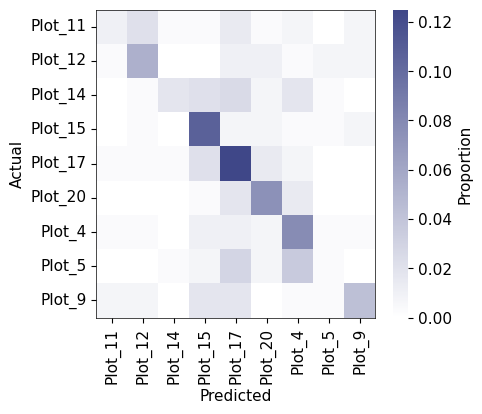

In [5]:
# Assuming y_true and predictions are already defined
cm = confusion_matrix(y_true, predictions)
labels = sorted(y_true.unique())  # Ensure correct label ordering

# Normalize the confusion matrix by the total sum to get proportions
cm_normalized = cm.astype('float') / cm.sum()

# Strip 'Lavaux_' from all labels
clean_labels = [label.replace("Lavaux_", "") for label in labels]

# Define custom colormap from light blue (not white) to deep blue
colors = ["#FFFFFF", "#3F4788FF"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=256)

# Create the heatmap with normalized confusion matrix
plt.figure(figsize=(4.5, 4))
plt.rcParams.update({'font.size': 11})
ax = sns.heatmap(cm_normalized, annot=False, fmt=".2f", cmap=custom_cmap, 
            cbar_kws={'label': 'Proportion'},  # Add colorbar label
            xticklabels=clean_labels, yticklabels=clean_labels)

# Add a single border around the heatmap (removes borders from individual cells)
for _, spine in ax.spines.items():
    spine.set_visible(True)  # Ensure border visibility
    spine.set_color('black')  # Set border color
    spine.set_linewidth(0.5)  # Set border thickness


plt.xlabel("Predicted")
plt.ylabel("Actual")

#plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/RF_ConfusionMatrix_must-harvest21-subset-classify-NCV.png', dpi=1000, bbox_inches='tight')  

plt.show()

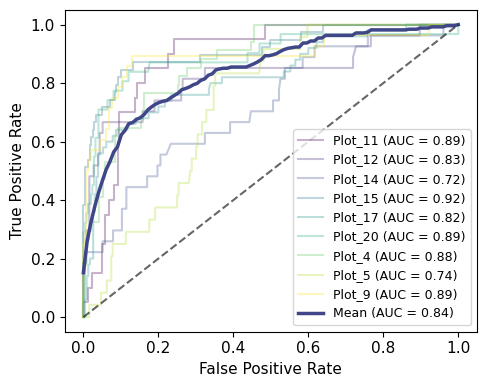

In [6]:
# Convert categorical labels to one-hot encoding
y_true_bin = label_binarize(y_true, classes=labels)

# Get Viridis colors for each class
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))  # Use plt.cm.viridis

# Compute ROC curve and AUC for each class
plt.figure(figsize=(5, 4))

plt.rcParams.update({'font.size': 11})
all_fpr = np.linspace(0, 1, 100)  # Common FPR points for interpolation
mean_tpr = np.zeros_like(all_fpr)  # To store mean TPR

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probabilities[label])
    roc_auc = auc(fpr, tpr)
    
    # Remove "Lavaux_" from the label in the legend
    clean_label = label.replace("Lavaux_", "")

    # Plot individual class ROC curve with Viridis color
    plt.plot(fpr, tpr, label=f"{clean_label} (AUC = {roc_auc:.2f})", 
             color=viridis_colors[i], alpha=0.3, linewidth=1.5)

    # Interpolate TPR for averaging
    mean_tpr += np.interp(all_fpr, fpr, tpr)  

# Compute mean ROC curve
mean_tpr /= len(labels)
mean_auc = auc(all_fpr, mean_tpr)

# Plot the **average ROC curve** (bold, different color)
plt.plot(all_fpr, mean_tpr, color="#3F4788FF", linewidth=2.5, label=f"Mean (AUC = {mean_auc:.2f})")

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.title("ROC Curve")
plt.legend(loc="lower right", fontsize=9)

#plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/RF_AUC_must-harvest21-subset-classify-NCV.png', dpi=1000, bbox_inches='tight')  

plt.tight_layout()
plt.show()

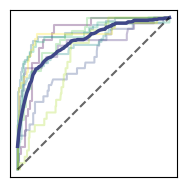

In [8]:
# Convert categorical labels to one-hot encoding
y_true_bin = label_binarize(y_true, classes=labels)

# Get Viridis colors for each class
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))  # Use plt.cm.viridis

# Compute ROC curve and AUC for each class
plt.figure(figsize=(2, 2))

plt.rcParams.update({'font.size': 11})
all_fpr = np.linspace(0, 1, 100)  # Common FPR points for interpolation
mean_tpr = np.zeros_like(all_fpr)  # To store mean TPR

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probabilities[label])
    roc_auc = auc(fpr, tpr)
    
    # Remove "Lavaux_" from the label in the legend
    clean_label = label.replace("Lavaux_", "")

    # Plot individual class ROC curve with Viridis color
    plt.plot(fpr, tpr, label=f"{clean_label} (AUC = {roc_auc:.2f})", 
             color=viridis_colors[i], alpha=0.3, linewidth=1.5)

    # Interpolate TPR for averaging
    mean_tpr += np.interp(all_fpr, fpr, tpr)  

# Compute mean ROC curve
mean_tpr /= len(labels)
mean_auc = auc(all_fpr, mean_tpr)

# Plot the **average ROC curve** (bold, different color)
plt.plot(all_fpr, mean_tpr, color="#3F4788FF", linewidth=2.5, label=f"Mean (AUC = {mean_auc:.2f})")

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)

# Get the current axis
ax = plt.gca()

# Remove axis labels, ticks, and tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.tight_layout()
plt.show()
